### Walkthrough example of preprocessing a worm dataset (`Kato2015`) 
---

This notebook aims to introduce our `Kato2015` dataset, obtained from the paper:
> Kato, Saul, Harris S. Kaplan, Tina Schrödel, Susanne Skora, Theodore H. Lindsay, Eviatar Yemini, Shawn Lockery, and Manuel Zimmer. 2015. “Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis Elegans.” Cell 163 (3): 656–69.

We will provide a detailed overview of how the raw data is organized and preprocessed. Although slight modifications may be required for other datasets, the overall methodology remains consistent.

*Last updated: 30 September 2023*

In [162]:
# @title Imports

import matplotlib.pyplot as plt
import mat73
import numpy as np
import os
import seaborn as sns
import subprocess
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.data import download_url

from preprocess._utils import (
    interpolate_data,
    reshape_calcium_data,
    smooth_data_preprocess,
)
from utils import NEURONS_302, ROOT_DIR

In [163]:
# @title Setup

# set numpy random seed
np.random.seed(42)

# download Kato2015 dataset
url = "https://www.dropbox.com/s/5r5cyxoads3iglz/opensource_data.zip?dl=1"
zipfile = "opensource_data.zip"
zip_path = os.path.join(ROOT_DIR, zipfile)
source_path = os.path.join(ROOT_DIR, zipfile.strip(".zip"))

if not os.path.exists(source_path):
    download_url(url=url, folder=ROOT_DIR, filename=zipfile)
    # unzip the Kato2015 folder
    bash_command = [
        "unzip",
        zip_path,
        "{}/*".format("Kato2015"),
        "-d",
        source_path,
    ]
    std_out = subprocess.run(bash_command, text=True)  # Run the bash command
    print(std_out, end="\n\n")
    # delete the zip file
    os.unlink(zip_path)
else:
    print("Kato2015 dataset already downloaded and unzipped.")

DATA_DIR = os.path.join(source_path, "Kato2015")

Kato2015 dataset already downloaded and unzipped.


In [164]:
# @title Helper Functions


# Function to print n elements of a list
def print_list(l, n):
    for i in range(n):
        print(l[i])


# Function to pick non-none element from a list
def pick_non_none(l):
    for i in range(len(l)):
        if l[i] is not None:
            return l[i]


# Function to determine the similarity between two neurons
def neuron_similarity(neuron1, neuron2):
    neuron1 = neuron1.detach().numpy()
    neuron2 = neuron2.detach().numpy()
    return np.sum(neuron1.T @ neuron2) / (
        np.linalg.norm(neuron1) * np.linalg.norm(neuron2)
    )


# Function for plotting calcium signals
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True, title=""):
    assert isinstance(data, torch.Tensor), "`data` must be a PyTorch tensor"
    assert isinstance(
        time_tensor, torch.Tensor
    ), "`time_tensor` must be a PyTorch tensor"
    assert data.dim() == 2, "`data` must be a 2D tensor"
    assert isinstance(
        neuron_idx, (int, list)
    ), "`neuron_idx` must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(
        0
    ), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert (
            neuron_idx <= num_neurons
        ), "`neuron_idx` cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert (
            len(neuron_idx) <= num_neurons
        ), "`neuron_idx` cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("Neuron {}".format(column_indices[i]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    plt.suptitle(title)
    plt.show()

# Raw data structure
---

The `Kato2015` dataset is split into two MATLAB documents: `WT_Stim.mat` and `WT_NoStim.mat`. Here is how they are structured:

* `traces_raw` = neural activity traces uncorrected
* `traces` = neural activity traces corrected for bleaching
* `tracesDif` = derivative of traces
* `IDs` = identified neuron IDs
* `timeVectorSeconds` = time vector in seconds
* `fps` = frames per second
* `dataset` = name of dataset
* `stimulus`
	* `identity` = what was changed e.g. $O_2$ (oxygen)
	* `type` = stimulus type e.g. binary steps
	* `switchtimes` =  time in seconds when stimulus changed from initial state to the other state
	* `initialstate` = the state that the stimulus starts with, refers to "conc"
	* `conc` = the concentrations of the stimulus
	* `concunits` - units of the "conc"

`States` = vector of different state types ($8$ states for `WT_NoStim`, $4$ states for `WT_Stim` and `AVA_HisCl`)

* $8$ states for `WT_NoStim`:
	* ‘FWD’ forward crawling 
	* ‘SLOW’ forward slowing
	* ‘DT’ dorsal post reversal turn
	* ‘VT’ ventral post reversal turn
	* ‘REV1’ reverse crawling
	* ‘REV2’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘NOSTATE’ - ambiguous
  
* $4$ states for `WT_Stim` and `AVA_HisCl`:
	* ‘FWD’ forward crawling 
	* ‘REV’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘TURN’ post reversal turn

# Processing the data
---

In [165]:
# Loading the data
dataset_raw = mat73.loadmat(os.path.join(DATA_DIR, "WT_Stim.mat"))[
    "WT_Stim"
]  # Return a dict
print("Raw data keys:", dataset_raw.keys(), end="\n\n")

# We will use just these features
features = ["IDs", "traces", "timeVectorSeconds"]
sizes = {}
for ft in features:
    sizes[ft] = [len(data) for data in dataset_raw[ft]]
print("The features have the following sizes:")
for ft in features:
    print(" {}: {}".format(ft, sizes[ft]))

Raw data keys: dict_keys(['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw'])

The features have the following sizes:
 IDs: [107, 122, 124, 134, 123, 151, 146]
 traces: [2198, 2017, 2197, 2018, 2201, 2017, 2019]
 timeVectorSeconds: [2198, 2017, 2197, 2018, 2201, 2017, 2019]


## Extracting neuron IDs
---

In [166]:
# Let's take a look at the IDs
print_list(dataset_raw["IDs"], 2)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['IL1DR', 'URYDR'], None, None, None, None, ['IL1DL', 'URYDL'], ['OLQDR', 'URYDR'], ['OLQVR', 'URYVR'], ['OLQVL', 'URYVL'], ['OLQDL', 'URYDL'], None, None, ['BAGL'], ['BAGR'], ['RMED'], ['RMEL'], None, None, ['RID'], None, None, ['RMEV'], ['ASKR'], [None, 'AFDL', 'ASKL'], ['AVAL'], None, ['ASKL', 'AFDL'], ['URXL', 'URXR'], ['ALA'], None, None, None, None, ['AVEL'], None, None, None, None, None, None, None, ['RIVL', 'AVHL', 'AVJL'], ['AIBR'], None, ['AVBL'], ['AIBL'], None, ['RIMR'], None, None, None, ['RIBL'], None, None, ['RIBR'], None, ['SMBDR', None], ['RIML'], None, None, None, None, None, None, None, None, None, None, None, ['RIS'], ['VB02'], None, ['AVFR'], ['SABVL', 'SABVR'], ['AVFL'], ['SABVR', None], ['RIFR'], None, ['VB01'], None, [None, 'RIGR'], ['SABD'], ['VA01'], ['RIGL'], None, ['SMDVL'], None, ['AVAR'], ['AVBR'], ['DB01'], ['DB02']]
[None, None, None, None, None, None, None, 

In [167]:
# Each list represents a worm. We need to extract just the neurons that were recorded.

# Example for the 5th worm.
oneID = dataset_raw["IDs"][4]
print("Raw IDs ({}): {}".format(len(oneID), oneID))
oneID = [
    (pick_non_none(j) if isinstance(j, list) else j) for j in oneID
]  # Just the first active neuron
oneID = [
    (str(_) if j is None or isinstance(j, np.ndarray) else str(j))
    for _, j in enumerate(oneID)
]  # Position on the list or name of the neuron
print("None to position ({}): {}".format(len(oneID), oneID))
_, inds = np.unique(oneID, return_index=True)  # Get unique neurons and their indices
oneID = [oneID[i] for i in inds]  # Get unique neurons
print("Unique neurons ({}): {}".format(len(oneID), oneID))

Raw IDs (123): [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['URYDR'], ['URYVL'], ['URYVR'], ['URADL'], ['URADR'], ['URYDL'], None, None, None, ['BAGL'], ['OLQVR'], None, None, ['OLQDL', 'URYDL'], ['OLQVL', 'URYVL'], ['OLQDR', 'URYDR'], ['BAGR'], ['RMER'], ['RMEL'], ['RMED'], None, ['RMEV'], None, None, ['RID'], None, ['AVAL'], None, ['---'], ['RMDVL'], ['---'], ['---', '---'], ['AVAR'], ['SMDVR'], ['ALA'], ['AVEL'], None, None, None, None, ['AVER'], ['URXL', 'URXR'], None, None, None, None, None, None, None, None, ['AIBL'], ['AIBR'], None, None, ['RIBL'], None, None, None, None, ['SIADR', None, '---'], None, ['AVBR'], ['AVBL'], None, None, ['RIBR'], None, None, None, None, None, ['RIMR'], ['RIVR', '---', '---'], None, None, None, None, None, ['RIML'], ['SMBDL'], None, None, None, ['SMBDR'], None, None, None, None, None, None, None, None, None, None, None, None, ['RIS'], None, None, ['VB02'], ['AVFR'], ['SABVR', 'SABVL'], ['AVFL

After extracting the labels, we obtain a list that contains the indices of the neurons. In cases where a neuron couldn't be identified, it is assigned a numerical value. To obtain a list of unique labels, we can utilize the `np.unique` function.

# Extracting the Traces
---

By utilizing the ordering of the unique neuron labels obtained from the numpy unique function, we can reorganize the columns of the calcium data. This reorganization ensures that the columns align with the specific neurons they represent, facilitating data analysis and interpretation.

In [168]:
# Using just the unique neurons, we can extract the traces
oneTrace_ = dataset_raw["traces"][4]
oneTrace_ = oneTrace_[:, inds]  # reordering columns
print("Unique traces: {}".format(oneTrace_.shape[1]))

Unique traces: 121


# Mapping the neurons
---

In [169]:
# Here is how we map the neurons to indices
idx_to_neuron = {
    nid: (str(nid) if (j is None or isinstance(j, np.ndarray)) else str(j))
    for nid, j in enumerate(oneID)
}

print(idx_to_neuron)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB02', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 9

In [170]:
# Format the neuron names if it finishes with 0
idx_to_neuron = {
    nid: (
        name.replace("0", "")
        if not name.endswith("0") and not name.isnumeric()
        else name
    )
    for nid, name in idx_to_neuron.items()
}
print(idx_to_neuron)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96

Notice that even after being relatively careful, we still ended up with a neuron labeled `---`. This speaks to the difficulty and importance of carefully inspecting and cleaning raw data. This nonsense label will end up being removed by the next step, which checks the neuron labels against a standardized set of neuron names for all of the $302$ neurons in _C. elegans_ hermaphrodite.  

In [171]:
# Standardize the neuron ordering
idx_to_neuron = {
    nid: (str(nid) if name not in set(NEURONS_302) else name)
    for nid, name in idx_to_neuron.items()
}
print(idx_to_neuron)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96: 'RID', 97: 'R

In [172]:
# Invert the mapping
neuron_to_idx = dict((v, k) for k, v in idx_to_neuron.items())
print(neuron_to_idx)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, 'AIBL': 76, 'AIBR': 77, 'ALA': 78, 'AVAL': 79, 'AVAR': 80, 'AVBL': 81, 'AVBR': 82, 'AVEL': 83, 'AVER': 84, 'AVFL': 85, 'AVFR': 86, 'BAGL': 87, 'BAGR': 88, 'DB2': 89, 'OLQDL': 90, 'OLQDR': 91, 'OLQVL': 92, 'OLQVR': 93, 'RIBL': 94, 'RIBR': 95, 'RID': 96, 'RIGR'

In [173]:
# Only some recorded neurons are definitively ID'd
num_named_neurons = len(
    [k for k in neuron_to_idx.keys() if not k.isnumeric()]
)  # number of neurons that were labeled with a name
print("Number of named neurons:", num_named_neurons)

Number of named neurons: 45


# Extracting signals
---

Time vector: (2201, 1)


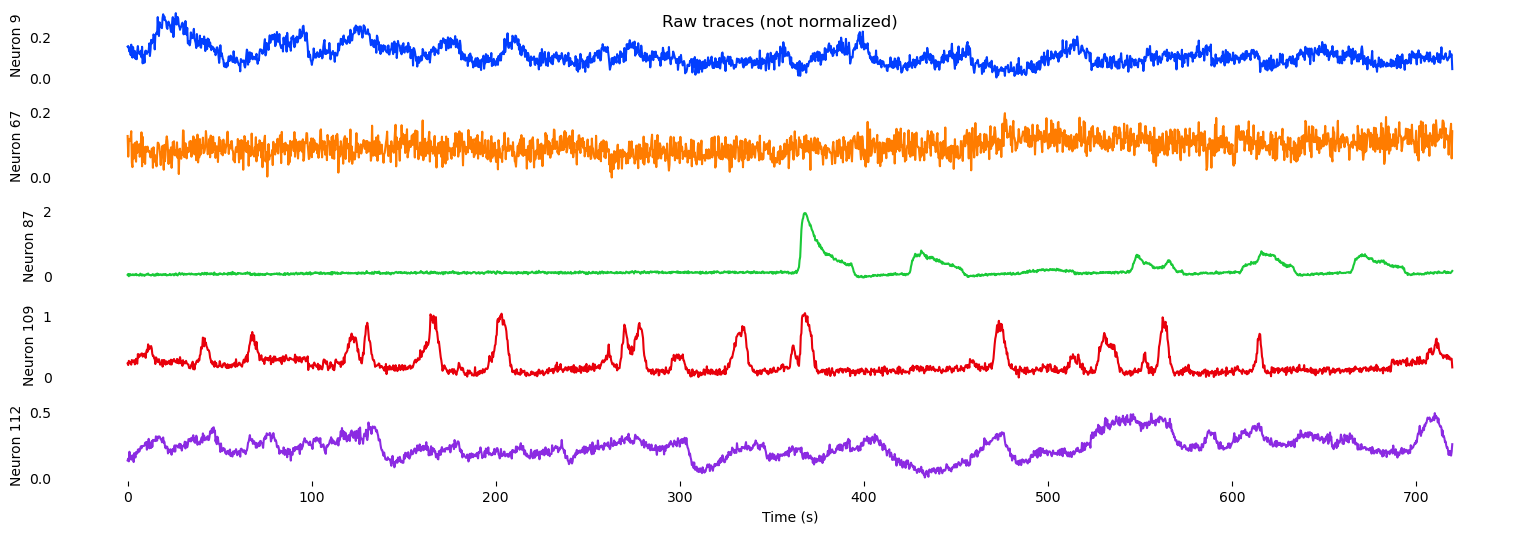

In [174]:
# Reshape time vector into a column vector
oneTime_ = dataset_raw["timeVectorSeconds"][4]
oneTime_ = oneTime_.reshape(-1, 1)
print("Time vector: {}".format(oneTime_.shape))

# Let's plot the raw traces
plot_signals(  # this function works with PyTorch tensors
    torch.from_numpy(oneTrace_).float(),
    torch.from_numpy(oneTime_).float(),
    [9, 67, 87, 109, 112],
    yax_limit=False,
    title="Raw traces (not normalized)",
)

# Transforming data
---

Time step difference: [0.32712403 0.32712403 0.32712406 ... 0.3270874  0.32714844 0.3270874 ]


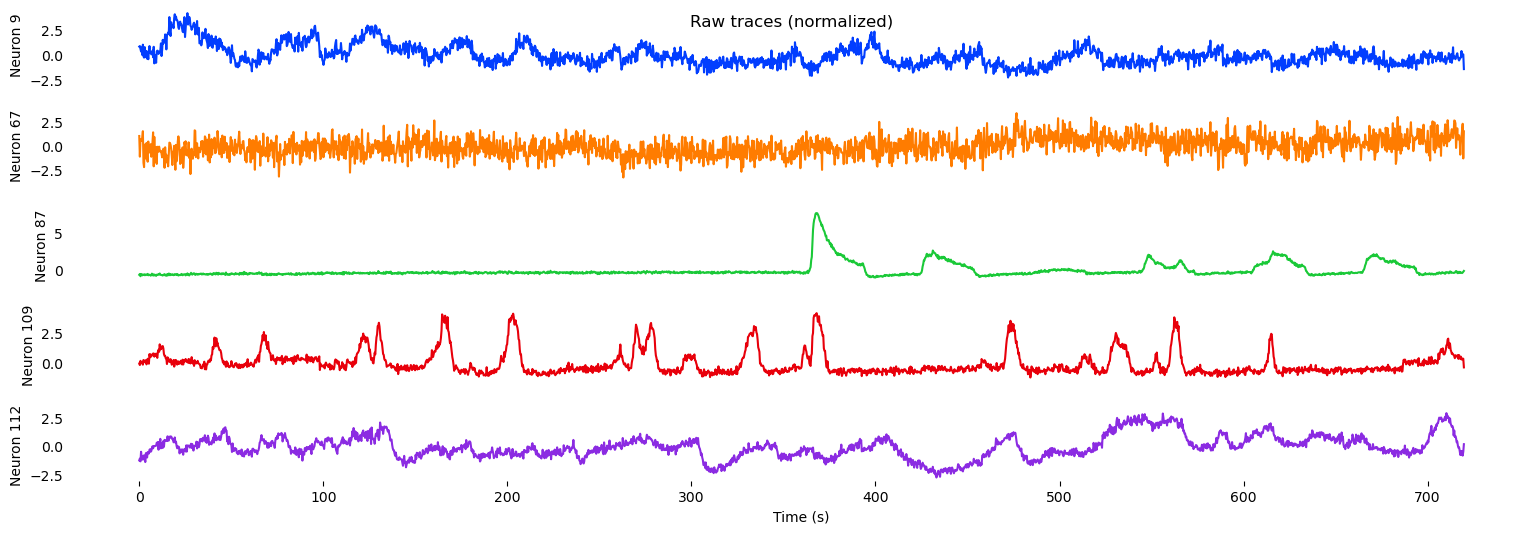

Time vector: torch.Size([2201, 1])
Unique traces: torch.Size([2201, 121])


In [175]:
# We normalize the traces
transform = StandardScaler()
oneTrace_norm = transform.fit_transform(oneTrace_)  # returns a numpy array
oneTime = torch.from_numpy(oneTime_).float()
oneTrace = torch.from_numpy(oneTrace_norm).float()

# Print difference between consecutive time steps of interpolated oneTime
print("Time step difference: {}".format(np.diff(oneTime.flatten())))

# Let's plot the normalized traces
plot_signals(
    oneTrace,
    oneTime,
    [9, 67, 87, 109, 112],
    yax_limit=False,
    title="Raw traces (normalized)",
)

print("Time vector: {}".format(oneTime.shape))
print("Unique traces: {}".format(oneTrace.shape))

# Resampling and smoothing
---

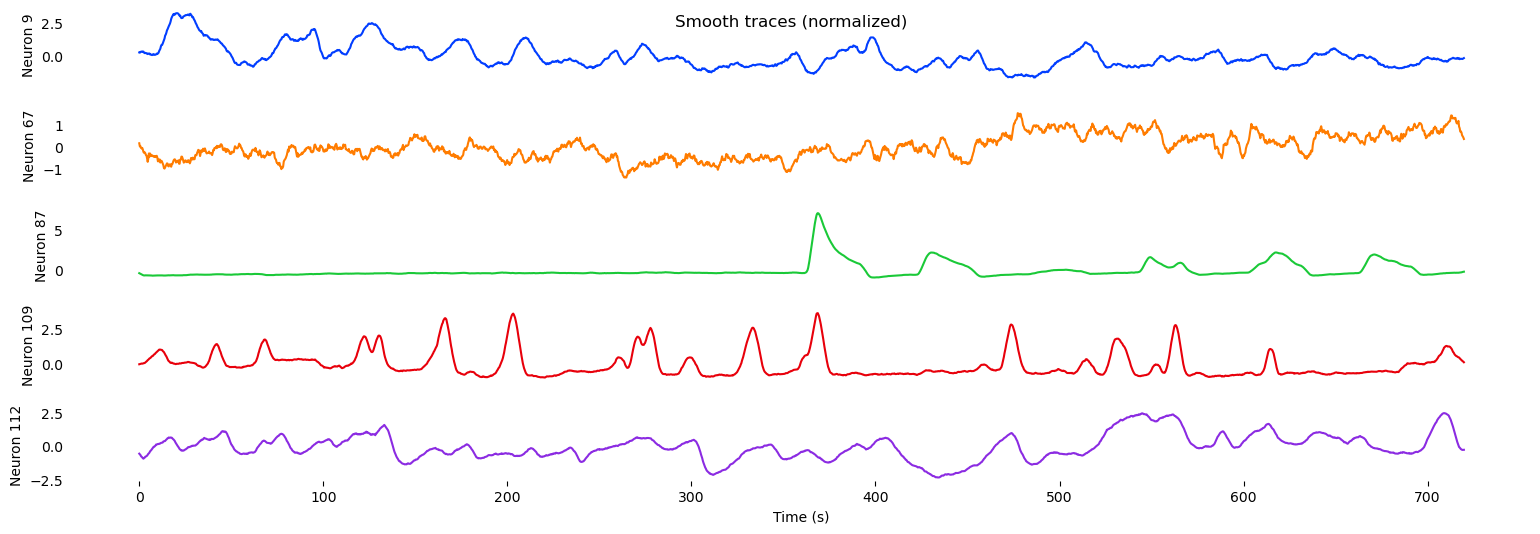

In [176]:
# We create a vector containing the time steps
dt = np.gradient(oneTime, axis=0)
dt[dt == 0] = np.finfo(
    float
).eps  # assigning a very small positive value to any element equal to zero.
original_median_dt = np.median(dt).item()

# Choose the smoothing method
smoother = "MA"

# Let's also compute the residual calcium
oneResidual = torch.from_numpy(np.gradient(oneTrace, axis=0) / dt).float()

# Let's smooth the residual and calcium data
oneResidual_smooth = smooth_data_preprocess(
    oneResidual, time_in_seconds=oneTime, smooth_method=smoother
)

oneTrace_smooth = smooth_data_preprocess(
    oneTrace, time_in_seconds=oneTime, smooth_method=smoother
)

# Plot the smooth calcium traces
plot_signals(
    oneTrace_smooth,
    oneTime,
    [9, 67, 87, 109, 112],
    yax_limit=False,
    title="Smooth traces (normalized)",
)

Time step difference: [0.1 0.1 0.1 ... 0.1 0.1 0.1]


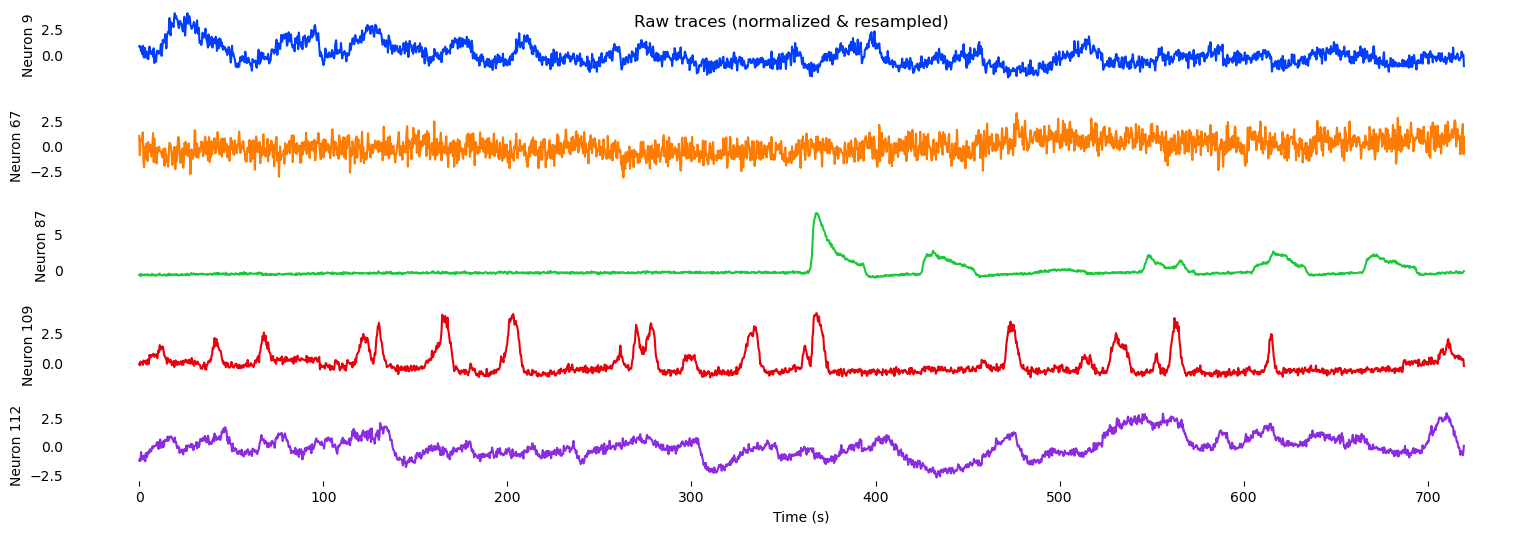

Time vector: (7197,)
Unique traces: (7197, 121)


In [177]:
# We resample the signal to a fixed time step
resample_median_dt = 0.10
oneTime_interp, oneTrace_interp = interpolate_data(
    oneTime, oneTrace, target_dt=resample_median_dt
)

# Also resample the residual
_, oneResidual_interp = interpolate_data(
    oneTime, oneResidual, target_dt=resample_median_dt
)

# Print difference between consecutive time steps of interpolated oneTime
print("Time step difference: {}".format(np.diff(oneTime_interp.flatten())))

# Let's plot the resampled traces
plot_signals(
    torch.from_numpy(oneTrace_interp),
    torch.from_numpy(oneTime_interp),
    [9, 67, 87, 109, 112],
    yax_limit=False,
    title="Raw traces (normalized & resampled)",
)

print("Time vector: {}".format(oneTime_interp.shape))
print("Unique traces: {}".format(oneTrace_interp.shape))

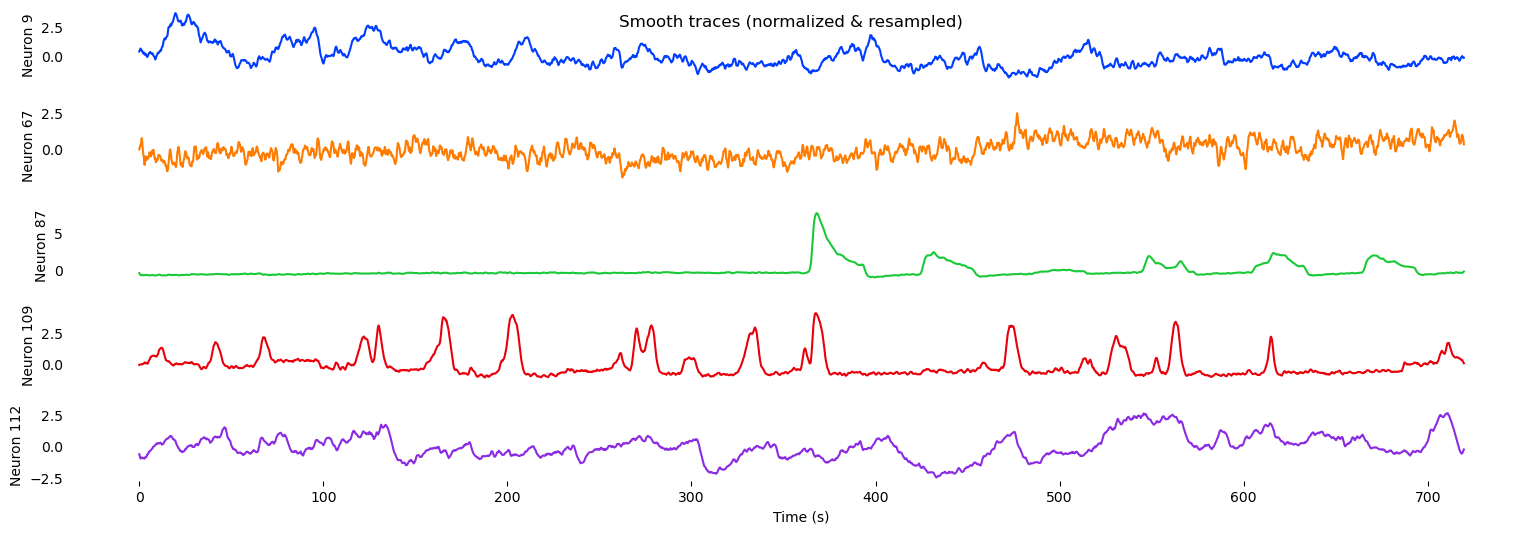

In [178]:
# Now, we smooth the resampled data using the moving average method
oneTrace_interp_smooth = smooth_data_preprocess(
    oneTrace_interp,
    time_in_seconds=oneTime_interp,
    smooth_method=smoother,
)

# Let's also smooth the residual calcium
oneResidual_interp_smooth = smooth_data_preprocess(
    oneResidual_interp,
    time_in_seconds=oneTime_interp,
    smooth_method=smoother,
)

# Let's plot the smoothed and interploated traces
plot_signals(
    torch.from_numpy(oneTrace_interp_smooth),
    torch.from_numpy(oneTime_interp),
    [9, 67, 87, 109, 112],
    yax_limit=False,
    title="Smooth traces (normalized & resampled)",
)

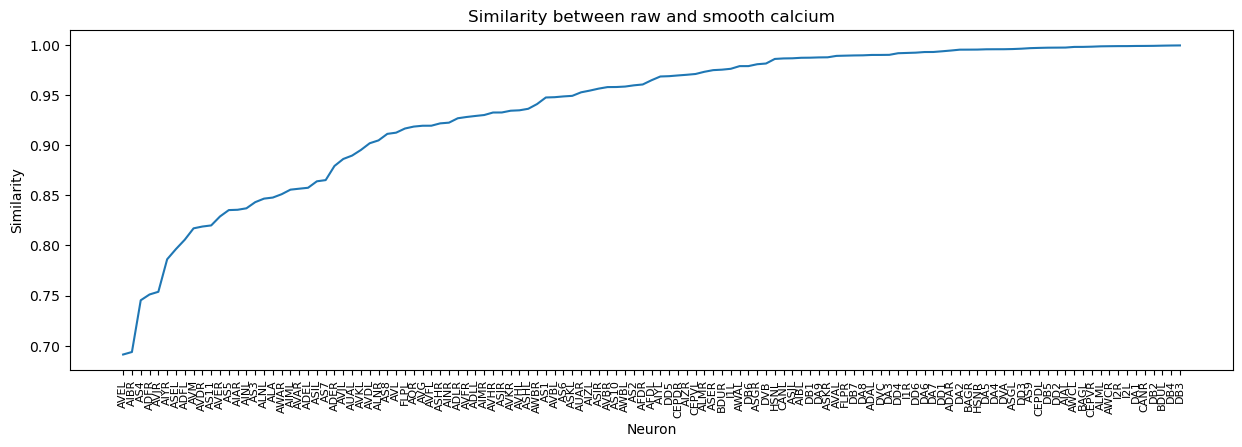

In [179]:
# Let's see the similarity between the raw and smooth traces (both resampled and normalized)
sim = []
for n in range(oneTrace_interp_smooth.shape[1]):
    sim.append(
        neuron_similarity(
            torch.from_numpy(oneTrace_interp_smooth[:, n]),
            torch.from_numpy(oneTrace_interp[:, n]),
        )
    )
sorted_sim, indices = np.sort(sim), np.argsort(sim)
sorted_neurons = np.array(NEURONS_302)[indices]

# Let's plot the similarity
plt.figure(figsize=(15, 5))
plt.plot(sorted_neurons, sorted_sim)
plt.xticks(rotation=90, fontsize=8)
plt.subplots_adjust(bottom=0.2)
plt.title("Similarity between raw and smooth calcium")
plt.xlabel("Neuron")
plt.ylabel("Similarity")
plt.show()

# Saving the data
---

In [180]:
# Finally we need to reshape the data to a standard format

# First we save all the data inside a data dict to pass to the function
oneDict = {}
oneDict.update(  # this tells us all the keys needed for a new raw dataset
    {
        "worm0": {
            "original_median_dt": original_median_dt,
            "original_calcium_data": oneTrace.numpy(),
            "original_smooth_calcium_data": oneTrace_smooth.numpy(),
            "original_residual_calcium": oneResidual.numpy(),
            "original_smooth_residual_calcium": oneResidual_smooth.numpy(),
            "original_max_timesteps": int(oneTrace.shape[0]),
            "original_time_in_seconds": oneTime.numpy(),
            "dataset": "Kato2015",
            "smooth_method": "MA",
            "worm": "worm0",
            "calcium_data": oneTrace_interp,
            "smooth_calcium_data": oneTrace_interp_smooth,
            "residual_calcium": oneResidual_interp,
            "smooth_residual_calcium": oneResidual_interp_smooth,
            "neuron_to_idx": neuron_to_idx,
            "idx_to_neuron": dict((v, k) for k, v in neuron_to_idx.items()),
            "max_timesteps": int(oneTrace_interp.shape[0]),
            "time_in_seconds": oneTime_interp,
            "resample_median_dt": resample_median_dt,
            "dt": dt,
            "num_neurons": int(oneTrace_interp.shape[1]),  # labeled + unlabeled
            "num_named_neurons": num_named_neurons,  # labeled
            "num_unknown_neurons": oneTrace_interp.shape[1]
            - num_named_neurons,  # unlabeled
        },
    }
)

In [181]:
# Now we can call the function to reshape the data  to a standard format
oneDict_standard = reshape_calcium_data(oneDict["worm0"])

# Here are the keys of the final dict
for key in sorted(oneDict_standard.keys()):
    print(key)

calcium_data
dataset
dt
max_timesteps
named_neuron_to_slot
named_neurons_mask
neuron_to_slot
neurons_mask
num_named_neurons
num_neurons
num_unknown_neurons
original_calcium_data
original_dt
original_max_timesteps
original_median_dt
original_residual_calcium
original_smooth_calcium_data
original_smooth_residual_calcium
original_time_in_seconds
resample_median_dt
residual_calcium
slot_to_named_neuron
slot_to_neuron
slot_to_unknown_neuron
smooth_calcium_data
smooth_method
smooth_residual_calcium
time_in_seconds
unknown_neuron_to_slot
unknown_neurons_mask
worm


In [183]:
# Let's print the shapes and values of the final dict
for key in oneDict_standard.keys():
    if type(oneDict_standard[key]) is str:
        print("{}: {}".format(key, oneDict_standard[key]))
    elif (type(oneDict_standard[key]) is float) or (type(oneDict_standard[key]) is int):
        print("{}: {}".format(key, oneDict_standard[key]))
    elif type(oneDict_standard[key]) is dict:
        print("{}: {}".format(key, len(oneDict_standard[key])))
    else:
        print("{}: {}".format(key, oneDict_standard[key].shape))

original_median_dt: 0.3271217346191406
original_calcium_data: torch.Size([2201, 302])
original_smooth_calcium_data: torch.Size([2201, 302])
original_residual_calcium: torch.Size([2201, 302])
original_smooth_residual_calcium: torch.Size([2201, 302])
original_max_timesteps: 2201
original_time_in_seconds: torch.Size([2201, 1])
dataset: Kato2015
smooth_method: MA
worm: worm0
calcium_data: torch.Size([7197, 302])
smooth_calcium_data: torch.Size([7197, 302])
residual_calcium: torch.Size([7197, 302])
smooth_residual_calcium: torch.Size([7197, 302])
max_timesteps: 7197
time_in_seconds: torch.Size([7197, 1])
resample_median_dt: 0.1
dt: torch.Size([7197, 1])
num_neurons: 121
num_named_neurons: 45
num_unknown_neurons: 76
named_neurons_mask: torch.Size([302])
unknown_neurons_mask: torch.Size([302])
neurons_mask: torch.Size([302])
slot_to_named_neuron: 45
named_neuron_to_slot: 45
slot_to_unknown_neuron: 76
unknown_neuron_to_slot: 76
slot_to_neuron: 121
neuron_to_slot: 121
original_dt: torch.Size([2

Now that the data is ready for use! Here is a description of each element within the dataset:

* `calcium_data`: (torch.tensor) The processed calcium data, with standardized shape. Shape: `(max_timesteps, 302)`.
* `dataset`: (str) Name of the dataset.
* `dt`: (torch.Tensor) A column vector of time intervals in seconds. Shape: `(max_timesteps, 1)`.
* `max_timesteps`: (float) Number of time steps in the processed data.
* `named_neuron_to_slot`: (dict) Mapping of labeled neuron -> column index. Len: `num_named_neurons`.
* `named_neurons_mask`: (torch.Tensor) A boolean vector with `True` at the indices of the labeled neurons. Shape: `(302)`.
* `neuron_to_slot`: (dict) Mapping of labeled / unlabeled neuron -> column index. Len: `num_neurons`.
* `neurons_mask`: (torch.Tensor) A bool vector indication the positions of all tracked neurons (labeled & unlabeled). Shape: `(302)`.
* `num_named_neurons`: (int) Number of labeled recorded neurons.
* `num_neurons`: (int) Number of all (labeled and unlabeled) recorded neurons.
* `num_unknown_neurons`: (int) Number of unlabeled recorded neurons.
* `original_calcium_data`: (torch.Tensor) The original calcium data. Shape: `(original_max_timesteps, num_neurons)`.
* `original_max_timesteps`: (int) Number of time steps in the original data. 
* `original_median_dt`: (float) The median `dt` of the original time series (i.e. before resampling). 
* `original_residual_calcium`: (torch.Tensor) The original calcium residual. Shape: `(original_max_timesteps, num_neurons)`.
* `original_smooth_calcium_data`: (torch.Tensor) The original calcium data, after smoothing. Shape: `(original_max_timesteps, num_neurons)`.
* `original_smooth_residual_calcium`: (torch.Tensor) The original calcium residual, after smoothing. Shape: `(original_max_timesteps, 302)`.
* `original_time_in_seconds`: (torch.Tensor) A column vector of times in seconds for the original data. Shape: `(original_max_timesteps, 1)`.
* `resample_median_dt`: (float) The constant `dt` of the processed time series (i.e. after resampling).
* `residual_calcium`: (torch.tensor) The processed calcium residual, with standardized shape. Shape: `(max_timesteps, 302)`.
* `smooth_calcium_data`: (torch.tensor) The processed calcium data, after smoothing, with standardized shape. Shape: `(max_timesteps, 302)`.
* `smooth_method`: (str) Method used for smoothing.
* `smooth_residual_calcium`: (torch.tensor) The residual calcium data, after smoothing, with standardized shape. Shape: `(max_timesteps, 302)`.
* `slot_to_named_neuron`: (dict) Mapping of column index -> labeled neuron. Len: `num_named_neurons`.
* `slot_to_neuron`: (dict) Mapping of column intex -> labeled / unlabeled neuron. Len: `num_neurons`.
* `slot_to_unknown_neuron`: (dict) Mapping of column index -> unlabeled neuron. Len: `num_unknown_neurons`.
* `time_in_seconds`: (torch.tensor) A column vector of times in seconds for the processed data. Shape: `(max_timesteps, 1)`.
* `unknown_neuron_to_slot`: (dict) Mapping of unlabeled neuron -> column index. Len: `num_unknown_neurons`.
* `unknown_neurons_mask`: (torch.tensor) A boolean vector with `True` at the indices of unlabeled neurons. Shape: `302`.
* `worm`: (str) The worm ID in the dataset.